<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/keras_fullGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### DOES NOT WORK YET - KERAS CANNOT HANDLE SYMBOLIC TENSORS FROM TF.PLACEHOLDER

!mkdir weights
!mkdir weights/target_model
!mkdir weights/generator
!mkdir weights/discriminator
!ls

mkdir: cannot create directory ‘weights’: File exists
mkdir: cannot create directory ‘weights/target_model’: File exists
mkdir: cannot create directory ‘weights/generator’: File exists
mkdir: cannot create directory ‘weights/discriminator’: File exists
sample_data  test.p  train.p  valid.p  weights


1.13.1


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 11s 324us/step - loss: 2.4806 - acc: 0.3094 - val_loss: 1.0817 - val_acc: 0.6937

Epoch 00001: saving model to weights/target_model/model.ckpt
Epoch 2/10
34799/34799 [==============================] - 9s 254us/step - loss: 1.0217 - acc: 0.6774 - val_loss: 0.5037 - val_acc: 0.8522

Epoch 00002: saving model to weights/target_model/model.ckpt
Epoch 3/10
34799/34799 [==============================] - 9s 252us/step - loss: 0.6990 - acc: 0.7817 - val_loss: 0.3087 - val_acc: 0.9145

Epoch 00003: saving model to weights/target_model/model.ckpt
Epoch 4/10
34799/34799 [==============================] - 9s 252us/step - loss: 0.5668 - acc: 0.8229 - val_loss: 0.

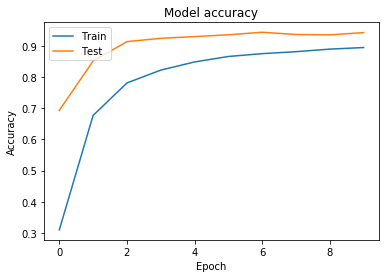

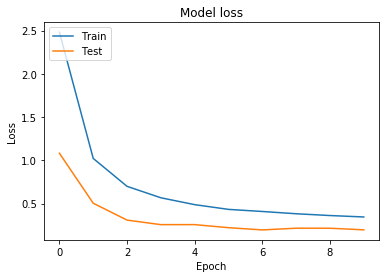

12630/12630 [==============================] - 1s 50us/step
Test accuracy: 93.67%


In [2]:
import numpy as np
np.random.seed(1187) #to help reproduce

import tensorflow as tf
print(tf.__version__)


import matplotlib.pyplot as plt
import os
import csv

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import keras
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.utils.np_utils import to_categorical



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

    
def create_model():
    #hyperparameters
    mu = 0
    sigma = 0.1
    n_out = 43
    learning_rate = 0.001

    #Start model
    model = Sequential()

    # LAYER 1 - Conv: Input 32x32x1, Output 28x28x6
    model.add(Conv2D(filters=6, 
                 kernel_size=5, 
                 strides=1, 
                 activation='relu', 
                 input_shape=(32,32,1)))


    # POOLING 1: Input = 28x28x6. Output = 14x14x6.
    #conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    # LAYER 2 - CONV: Input 14x14x6, Output 10x10x16
    model.add(Conv2D(filters=16,
                kernel_size=5,
                strides=1,
                activation='relu',
                input_shape=(14,14,6)))


    # POOLING 2: Input 10x10x16, Output 5x5x16
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    # FLATTEN
    model.add(Flatten())

    # LAYER 3: FC Input 400, Output 120
    model.add(Dense(units=120, activation='relu'))
    model.add(Dropout(0.4))

    # LAYER 4: FC Input 120, Output 84
    model.add(Dense(units=84, activation='relu'))
    model.add(Dropout(0.4))

    # LAYER 5: SOFTMAX Input 84, Output 43
    model.add(Dense(units=43, activation='softmax'))



    # Compile model
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    
    return model

      
import pickle

if __name__ == '__main__':
    training_file = 'train.p'
    testing_file = 'test.p'
    validation_file = 'valid.p'

    with open(training_file, mode='rb') as f:
        tstrain = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        tstest = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        tsvalid = pickle.load(f)

    X_train, Y_train = tstrain['features'], tstrain['labels']
    X_valid, Y_valid = tsvalid['features'], tsvalid['labels']
    X_test, Y_test = tstest['features'], tstest['labels']

    #shuffle training set
    X_train, Y_train = shuffle(X_train, Y_train, random_state=33)
    X_test, Y_test = shuffle(X_test, Y_test, random_state=33)
    X_valid, Y_valid = shuffle(X_valid, Y_valid, random_state=33)

    #grayscale images
    grayscale = [0.299,0.587,0.144]

    X_test = np.dot(X_test, grayscale)
    X_train = np.dot(X_train, grayscale)
    X_valid = np.dot(X_valid, grayscale)


    #normalize
    X_train = np.array(X_train)/255
    X_test = np.array(X_test)/255
    X_valid = np.array(X_valid)/255

    #expand dimensions to fit 4D input array
    X_train = np.expand_dims(X_train,-1)
    X_test = np.expand_dims(X_test,-1)
    X_valid = np.expand_dims(X_valid,-1)

    assert(len(X_train)==len(Y_train))
    n_train = len(X_train)
    assert(len(X_test)==len(Y_test))
    n_test = len(X_test)
    
    Y_train = to_categorical(Y_train, num_classes=43)
    Y_test = to_categorical(Y_test, num_classes=43)
    Y_valid = to_categorical(Y_valid, num_classes=43)
    
    checkpoint_path = "weights/target_model/model.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                     save_weights_only=True, 
                                     verbose=1)
    model = create_model()
    model.summary
    history = model.fit(X_train, Y_train, epochs=10, batch_size=20, 
              validation_data = (X_valid, Y_valid), 
              callbacks=[cp_callback])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    
    loss, acc = model.evaluate(X_test, Y_test)
    print("Test accuracy: {:5.2f}%".format(100*acc))

In [3]:
modeltest = create_model()

#Check untrained first
loss, acc = modeltest.evaluate(X_test, Y_test)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

#Now restore model and check accuracy
modeltest.load_weights(checkpoint_path)
loss,acc = modeltest.evaluate(X_test, Y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

12630/12630 [==============================] - 1s 59us/step
Untrained model, accuracy:  1.51%
12630/12630 [==============================] - 1s 48us/step
Restored model, accuracy: 93.67%


In [4]:

#Generator
'''
	Generator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''
'''

#helper function if we use residual blocks
class ResBlock(Layer):
	def __init__(self, channels_in, kernel, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =   Activation("linear", trainable=False)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(first_layer)
        x = BatchNormalization()(x)
        x =             Activation("relu")(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(x)
        x = BatchNormalization()(x)
        residual =      Add()([x, first_layer])
        x =             Activation("relu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape
    

def create_generator():
    
    generator = Sequential()
    generator.add(Conv2D(filters=32, kernel_size=3, strides=1))
    generator.add(LeakyRelu(0.2))
    generator.add(InstanceNormalization())

    generator.add(Conv2D(filters=64, kernel_size=3, strides=2))
    generator.add(LeakyRelu(0.2))
    generator.add(InstanceNormalization())

    generator.add(Conv2D(filters=128, kernel_size=3, strides=2))
    generator.add(LeakyRelu(0.2))
    generator.add(InstanceNormalization())

    #generator.add(ResBlock(128, (3,3)))
    #generator.add(ResBlock(128, (3,3)))
    #generator.add(ResBlock(128, (3,3)))
    #generator.add(ResBlock(128, (3,3)))

    generator.add(Conv2DTranspose(filters=64, kernel_size=3, strides=2))
    generator.add(InstanceNormalization())
    generator.add(LeakyRelu(0.2))
    generator.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2))
    generator.add(InstanceNormalization())
    generator.add(LeakyRelu(0.2))
    
    generator.add(Conv2DTranspose(filters=1, kernel_size=3, 
                                  strides=1, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    
    return generator

gtest = create_generator()
gtest.summary()
'''

'\n\n#helper function if we use residual blocks\nclass ResBlock(Layer):\n\tdef __init__(self, channels_in, kernel, **kwargs):\n        super(Residual, self).__init__(**kwargs)\n        self.channels_in = channels_in\n        self.kernel = kernel\n\n    def call(self, x):\n        # the residual block using Keras functional API\n        first_layer =   Activation("linear", trainable=False)(x)\n        x =             Conv2D( self.channels_in,\n                                self.kernel,\n                                padding="same")(first_layer)\n        x = BatchNormalization()(x)\n        x =             Activation("relu")(x)\n        x =             Conv2D( self.channels_in,\n                                self.kernel,\n                                padding="same")(x)\n        x = BatchNormalization()(x)\n        residual =      Add()([x, first_layer])\n        x =             Activation("relu")(residual)\n        return x\n\n    def compute_output_shape(self, input_shape):\n  

In [5]:
#Discriminator
'''
	Discriminator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''
'''
#import tensorflow as tf


def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(filters=8, kernel_size=4, 
                             strides=2, padding='valid'))
    discriminator.add(LeakyRelu(0.2))
    
    discriminator.add(Conv2D(filters=16, kernel_size=4, 
                             strides=2, padding='valid'))
    discriminator.add(InstanceNormalization())
    discriminator.add(LeakyRely(0.2))
    discriminator.add(Conv2D(filters=32, kernel_size=4, 
                             strides=2, padding='valid'))
    discriminator.add(InstanceNormalization())
    discriminator.add(LeakyRely(0.2))
    discriminator.add(Flatten())
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    return discriminator

dtest = create_discriminator()
dtest.summary()
'''

"\n#import tensorflow as tf\n\n\ndef create_discriminator():\n    discriminator = Sequential()\n    discriminator.add(Conv2D(filters=8, kernel_size=4, \n                             strides=2, padding='valid'))\n    discriminator.add(LeakyRelu(0.2))\n    \n    discriminator.add(Conv2D(filters=16, kernel_size=4, \n                             strides=2, padding='valid'))\n    discriminator.add(InstanceNormalization())\n    discriminator.add(LeakyRely(0.2))\n    discriminator.add(Conv2D(filters=32, kernel_size=4, \n                             strides=2, padding='valid'))\n    discriminator.add(InstanceNormalization())\n    discriminator.add(LeakyRely(0.2))\n    discriminator.add(Flatten())\n    discriminator.add(Dense(units=1, activation='sigmoid'))\n    \n    return discriminator\n\ndtest = create_discriminator()\ndtest.summary()\n"

In [0]:
#Generator
'''
	Generator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''

#import tensorflow as tf
#from keras import layers

# helper function for convolution -> instance norm -> relu
def ConvInstNormRelu(x, filters, kernel_size=3, strides=1):
	Conv = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(Conv)

	return tf.nn.relu(InstNorm)


# helper function for trans convolution -> instance norm -> relu
def TransConvInstNormRelu(x, filters, kernel_size=3, strides=2):
	TransConv = tf.layers.conv2d_transpose(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(TransConv)

	return tf.nn.relu(InstNorm)

# helper function for residual block of 2 convolutions with same num filters
# in the same style as ConvInstNormRelu
def ResBlock(x, training, filters=32, kernel_size=3, strides=1):
	conv1 = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv1_norm = tf.layers.batch_normalization(conv1, training=training)

	conv1_relu = tf.nn.relu(conv1_norm)

	conv2 = tf.layers.conv2d(
						inputs=conv1_relu,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv2_norm = tf.layers.batch_normalization(conv2, training=training)


	return x + conv2_norm


def generator(x, training):
	with tf.variable_scope('g_weights', reuse=tf.AUTO_REUSE): #True
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])
        
        #6/3 increased all filters 4x
		# define first three conv + inst + relu layers
		c1 = ConvInstNormRelu(x, filters=32, kernel_size=3, strides=1)
		d1 = ConvInstNormRelu(c1, filters=64, kernel_size=3, strides=2)
		d2 = ConvInstNormRelu(d1, filters=128, kernel_size=3, strides=2)
        
        #then stride
		# define residual blocks
		rb1 = ResBlock(d2, training, filters=128)
		rb2 = ResBlock(rb1, training, filters=128)
		rb3 = ResBlock(rb2, training, filters=128)
		rb4 = ResBlock(rb3, training, filters=128)

		# upsample using conv transpose
		u1 = TransConvInstNormRelu(rb4, filters=64, kernel_size=3, strides=2)
		u2 = TransConvInstNormRelu(u1, filters=32, kernel_size=3, strides=2)

		# final layer block
		out = tf.layers.conv2d_transpose(
						inputs=u2,
						filters=x.get_shape()[-1].value, # or 3 if RGB image
						kernel_size=3,
						strides=1,
						padding="same",
						activation=None)

		# out = tf.contrib.layers.instance_norm(out)

		return tf.nn.tanh(out)

In [0]:
#Discriminator
'''
	Discriminator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''

#import tensorflow as tf

def discriminator(x, training):
	with tf.variable_scope('d_weights', reuse=tf.AUTO_REUSE):
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])

		conv1 = tf.layers.conv2d(
							inputs=x,
							filters=8,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)
		conv1 = tf.nn.leaky_relu(conv1, alpha=0.2)

		
		conv2 = tf.layers.conv2d(
							inputs=conv1,
							filters=16,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		in1 = tf.contrib.layers.instance_norm(conv2)
		conv2 = tf.nn.leaky_relu(in1, alpha=0.2)

		conv3 = tf.layers.conv2d(
							inputs=conv2,
							filters=32,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		#in2 = tf.contrib.layers.instance_norm(conv3)
		in2 = tf.contrib.layers.instance_norm(conv3)
		conv3 = tf.nn.leaky_relu(in2, alpha=0.2)
		flat = tf.layers.flatten(conv3)
		logits = tf.layers.dense(flat, 1)

		probs = tf.nn.sigmoid(logits)

		return logits, probs

In [9]:


# get the next batch based on x, y, and the iteration (based on batch_size)
def next_batch(X, Y, i, batch_size):
    idx = i * batch_size
    idx_n = i * batch_size + batch_size
    return X[idx:idx_n], Y[idx:idx_n]

# loss function to encourage misclassification after perturbation
def adv_loss(preds, labels, is_targeted):
    real = tf.reduce_sum(labels * preds, 1)
    other = tf.reduce_max((1 - labels) * preds - (labels * 10000), 1)
    if is_targeted:
        return tf.reduce_sum(tf.maximum(0.0, other - real))
    return tf.reduce_sum(tf.maximum(0.0, real - other))

# loss function to influence the perturbation to be as close to 0 as possible
def perturb_loss(preds, thresh=0.3):
    zeros = tf.zeros((tf.shape(preds)[0]))
    return tf.reduce_mean(tf.maximum(zeros, tf.norm(tf.reshape(preds, (tf.shape(preds)[0], -1)), axis=1) - thresh))


# function that defines ops, graphs, and training procedure for AdvGAN framework
def AdvGAN(X, y, X_test, y_test, epochs=50, batch_size=128, target=3):
    #print(X_train.shape)
    #print(y.shape[-1]) is num_images
    print("y shape")
    print(y.shape)
    print("y_test shape")
    print(y_test.shape)
    
    # placeholder definitions
    x_pl = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]]) # image placeholder
    t = tf.placeholder(tf.float32, [None, y.shape[-1]]) # target placeholder
    print("t shape)")
    print(t.shape)
    is_training = tf.placeholder(tf.bool, [])

    #-----------------------------------------------------------------------------------
    # MODEL DEFINITIONS
    is_targeted = False
    if target in range(0, y.shape[-1]):
        is_targeted = True

    #tf.reset_default_graph()
    
    # gather target model
    target_model = create_model()
    print("is targeted boolean")
    print(is_targeted)
    
    #test accuracy of restored model
    target_model.load_weights(checkpoint_path)
    loss,acc = target_model.evaluate(X_test, y_test)
    print("Restored model, accuracy: {:5.2f}%".format(100*acc))
    
    thresh = 0.3

    # generate perturbation, add to original input image(s)
    perturb = tf.clip_by_value(generator(x_pl, is_training), -thresh, thresh)
    x_perturbed = perturb + x_pl
    x_perturbed = tf.clip_by_value(x_perturbed, 0, 1)
    print(x_perturbed.shape)

    # pass real and perturbed image to discriminator and the target model
    d_real_logits, d_real_probs = discriminator(x_pl, is_training)
    d_fake_logits, d_fake_probs = discriminator(x_perturbed, is_training)
    print(d_fake_probs.shape)#1
    
    # pass real and perturbed images to the model we are trying to fool
    f_real_probs = target_model.predict(X)
    loss2,acc2 = target_model.evaluate(X, y)
    print("x_pl model, accuracy: {:5.2f}%".format(100*acc2))

    
    f_fake_probs = target_model.predict(x_perturbed)
    

    #f_real_logits, f_real_probs = f.ModelC(x_pl)
    #f_fake_logits, f_fake_probs = f.ModelC(x_perturbed)
    #print(f_fake_probs.shape) #43

    # generate labels for discriminator (optionally smooth labels for stability)
    smooth = 0.0
    d_labels_real = tf.ones_like(d_real_probs) * (1 - smooth)
    d_labels_fake = tf.zeros_like(d_fake_probs)

    #-----------------------------------------------------------------------------------
    # LOSS DEFINITIONS
    # discriminator loss
    d_loss_real = tf.losses.mean_squared_error(predictions=d_real_probs, labels=d_labels_real)
    d_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=d_labels_fake)
    d_loss = d_loss_real + d_loss_fake

    # generator loss
    g_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=tf.ones_like(d_fake_probs))

    # perturbation loss (minimize overall perturbation)
    l_perturb = perturb_loss(perturb, thresh)

    # adversarial loss (encourage misclassification)
    l_adv = adv_loss(f_fake_probs, t, is_targeted)

    # weights for generator loss function
    alpha = 1.0
    beta = 5.0
    g_loss = l_adv + alpha*g_loss_fake + beta*l_perturb 

    # ----------------------------------------------------------------------------------
    # gather variables for training/restoring
    t_vars = tf.trainable_variables()
    #f_vars = [var for var in t_vars if 'ModelC_' in var.name]
    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='g_weights')

    # define optimizers for discriminator and generator
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss, var_list=g_vars)

	# create saver objects for the target model, generator, and discriminator
    #saver = tf.train.Saver(f_vars)
    g_saver = tf.train.Saver(g_vars)
    d_saver = tf.train.Saver(d_vars)
  
    init  = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)

    total_batches = int(X.shape[0] / batch_size)

    for epoch in range(0, epochs):

        loss_D_sum = 0.0
        loss_G_fake_sum = 0.0
        loss_perturb_sum = 0.0
        loss_adv_sum = 0.0

        for i in range(total_batches):

            batch_x, batch_y = next_batch(X, y, i, batch_size)

            # if targeted, create one hot vectors of the target
            if is_targeted:
                targets = np.full((batch_y.shape[0],), target)
                batch_y = np.eye(y.shape[-1])[targets]

            # train the discriminator first 1 time
            for _ in range(1):
                _, loss_D_batch = sess.run([d_opt, d_loss], feed_dict={x_pl: batch_x, \
                                           is_training: True})

            
			# train the generator 1 time (maybe try 10 times (1:10 d:g))
            for _ in range(1):
                
                _, loss_G_fake_batch, loss_adv_batch, loss_perturb_batch = sess.run([g_opt, g_loss_fake, l_adv, l_perturb], 
                                                feed_dict={x_pl: batch_x, t: batch_y, 
                                                           is_training: True})

            loss_D_sum += loss_D_batch
            loss_G_fake_sum += loss_G_fake_batch
            loss_perturb_sum += loss_perturb_batch
            loss_adv_sum += loss_adv_batch

        print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f, \
            \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
            (epoch + 1, loss_D_sum/total_batches, loss_G_fake_sum/total_batches,
            loss_perturb_sum/total_batches, loss_adv_sum/total_batches))
    
        if epoch % 10 == 0:
            g_saver.save(sess, "weights/generator/gen")
            d_saver.save(sess, "weights/discriminator/disc")

    # evaluate the test set
    correct_prediction = tf.equal(tf.argmax(f_fake_probs, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accs = []
    total_batches_test = int(X_test.shape[0] / batch_size)
    for i in range(total_batches_test):
        batch_x, batch_y = next_batch(X_test, y_test, i, batch_size)
        acc, x_pert = sess.run([accuracy, x_perturbed], feed_dict={x_pl: batch_x, t: batch_y, is_training: False})
        accs.append(acc)

    print('accuracy of test set: {}'.format(sum(accs) / len(accs)))

	# plot some images and their perturbed counterparts
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(np.squeeze(batch_x[2]), cmap='Greys_r')
    axarr[0,1].imshow(np.squeeze(x_pert[2]), cmap='Greys_r')
    axarr[1,0].imshow(np.squeeze(batch_x[5]), cmap='Greys_r')
    axarr[1,1].imshow(np.squeeze(x_pert[5]), cmap='Greys_r')
    plt.show()

    print('finished training, saving weights')
    g_saver.save(sess, "weights/generator/gen")
    d_saver.save(sess, "weights/discriminator/disc")



def attack(X, y, batch_size=128, thresh=0.3, target=3):
    x_pl = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]]) # image placeholder
    t = tf.placeholder(tf.float32, [None, y.shape[-1]]) # target placeholder
    is_training = tf.placeholder(tf.bool, [])

    is_targeted = False
    if target in range(0, y.shape[-1]):
        is_targeted = True

    perturb = tf.clip_by_value(generator(x_pl, is_training), -thresh, thresh)
    x_perturbed = perturb + x_pl
    x_perturbed = tf.clip_by_value(x_perturbed, 0, 1)

    a = Target()
    a_real_logits, a_real_probs = a.ModelC(x_pl)
    a_fake_logits, a_fake_probs = a.ModelC(x_perturbed)

    #t_vars = tf.trainable_variables()
    #a_vars = [var for var in t_vars if 'ModelC' in var.name]
    g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='g_weights')

    init  = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)    
    
    #just using generator and target model
    new_saver2 = tf.train.import_meta_graph('./weights/target_model/model.ckpt.meta')
    new_saver2.restore(sess, tf.train.latest_checkpoint('./weights/target_model'))
    
    #f_saver2 = tf.train.Saver(a_vars)
    #g_saver = tf.train.Saver(g_vars)
    #f_saver2.restore(sess, "./weights/target_model/model")
    g_saver = tf.train.import_meta_graph('./weights/generator/gen.meta')
    g_saver.restore(sess, tf.train.latest_checkpoint("./weights/generator"))

    rawpert, pert, fake_l, real_l = sess.run([perturb, x_perturbed, a_fake_probs, a_real_probs], \
                          feed_dict={x_pl: X[:32], \
                                 is_training: False})
    
    #changed the way the author named these printed lists - please verify that I interpreted his acronyms properly
    print('actual labels: ' + str(np.argmax(y[:32], axis=1)))
    print('classifier original prediction: ' + str(np.argmax(real_l, axis=1))) 
    print('classifier prediction after perturbation: ' + str(np.argmax(fake_l, axis=1)))

    correct_prediction = tf.equal(tf.argmax(a_fake_probs, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accs = []
    total_batches_test = int(X.shape[0] / batch_size)
    for i in range(total_batches_test):
        batch_x, batch_y = next_batch(X, y, i, batch_size)

        if is_targeted:
            targets = np.full((batch_y.shape[0],), target)
            batch_y = np.eye(y.shape[-1])[targets]

        acc, fake_l, x_pert = sess.run([accuracy, a_fake_probs, x_perturbed], feed_dict={x_pl: batch_x, t: batch_y, is_training: False})
        accs.append(acc)

    print('accuracy of test set: {}'.format(sum(accs) / len(accs)))

    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(np.squeeze(X[3]), cmap='Greys_r')
    axarr[0,1].imshow(np.squeeze(pert[3]), cmap='Greys_r')
    axarr[1,0].imshow(np.squeeze(X[4]), cmap='Greys_r')
    axarr[1,1].imshow(np.squeeze(pert[4]), cmap='Greys_r')
    plt.show()


#main code
#Y_train = to_categorical(Y_train, num_classes=43)
#Y_test = to_categorical(Y_test, num_classes=43)
#Y_valid = to_categorical(Y_valid, num_classes=43)

AdvGAN(X_train, Y_train, X_test, Y_test, batch_size=128, epochs=50, target=3)

#attack(X_valid, Y_valid, target=3)

y shape
(34799, 43)
y_test shape
(12630, 43)
t shape)
(?, 43)
is targeted boolean
True
12630/12630 [==============================] - 1s 54us/step
Restored model, accuracy: 93.67%
Instructions for updating:
Use keras.layers.conv2d instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
(?, 32, 32, 1)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
(?, 1)
34799/34799 [==============================] - 2s 50us/step
x_pl model, accuracy: 98.69%


ValueError: ignored